In [ ]:
# importing libraries
import os
import random
import itertools
from math import radians, sin, cos, sqrt, atan2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from flask import Flask, request, render_template, send_from_directory

In [1]:
#reading all three files
airports=pd.read_csv('airportDataset.csv')
aircrafts=pd.read_csv('aircraftDataset.csv')
weathers=pd.read_csv('weatherDataset.csv')

#make a dictionary to rename the columns to ICAO codes.
city_to_ICAO={
    'Islamabad':'ISLA',
    'Gwadar':'GWAD',
    'Sukkur':'SUKK',
    'Gujranwala':'GUJR',
    'Sialkot':'SIAL',
    'Rawalpindi':'RAWA',
    'Faisalabad':'FAIS',
    'Multan':'MULT',
    'Quetta':'QUET',
    'Lahore':'LAHO',
    'Karachi':'KARA',
    'Peshawar':'PESH'
}

#finding the location to map it to ICAO codes
first_data=airports.head(12)
keys='City'
latitudes='Latitude'
longs='Longitude'
dictionary={}

#iterate through the columns, to add their longitude and Latitude
for i, row in first_data.iterrows():
    key=row[keys]
    Updatedkey=city_to_ICAO[key]
    
    lat=row[latitudes]
    long=row[longs]
    
    #creating the dictionary key=ICAO, val = (lat, long)
    if Updatedkey not in dictionary:
        dictionary[Updatedkey]=[]
    dictionary[Updatedkey].append((lat, long))
    
print(dictionary)


#finding the third column of the dataset and taking it's values
ICAO_START=airports.iloc[:, 3].values


#exporting the coordinates to a csv file for further use and documentation
data_coords=[]
for i,j in dictionary.items():
    for k in j:
        data_coords.append({'ICAO':i, 'Latitude':k[0], 'Longitude':k[1]})
newfile =pd.DataFrame(data_coords)

filename = 'coordinates.csv'

#exporting coordinates.csv
newfile.to_csv(filename,index=False)

{'PESH': [(71.5192, 33.9898)], 'KARA': [(67.1681, 24.9008)], 'LAHO': [(74.4104, 31.5203)], 'QUET': [(66.9488, 30.2491)], 'MULT': [(71.4237, 30.1962)], 'FAIS': [(72.9879, 31.3628)], 'RAWA': [(73.1039, 33.6088)], 'SIAL': [(74.3676, 32.5327)], 'GUJR': [(74.1945, 32.1877)], 'SUKK': [(68.7957, 27.7231)], 'GWAD': [(62.3317, 25.2314)], 'ISLA': [(72.8341, 33.5565)]}


In [2]:
#reading coordinates for application of haversine formula
newfile=pd.read_csv('coordinates.csv')

def distanceCalculator(lat1, long1, lat2, long2):
    #this is an application of the haversine formulae
    lat1, long1, lat2, long2=map(radians, [lat1, long1, lat2, long2])
    
    distLong=long2-long1
    distLat=lat2-lat1
    
    a =sin(distLat/2)**2 + cos(lat1)*cos(lat2) * sin(distLong/2)**2
    c =2*atan2(sqrt(a), sqrt(1-a))
    distance = c*6371
    
    #returns distance between the two 2d points
    return distance

#declaring the list to use for storing calculations. [city1, city2, distance]
listofDistances=[]

#going to save the distances in a new file.
for _,n1 in newfile.iterrows():
    #distance between each city and 12 other cities will be mapped incrementally.
    for _,n2 in newfile.iterrows():
        
        #condition to confirm that the city does not calculate the distance between itself.
        if n1['ICAO']!=n2['ICAO']:
            
            #calculate distance and append it to the list.
            distance=distanceCalculator(n1['Latitude'], n1['Longitude'], n2['Latitude'], n2['Longitude'])
            listofDistances.append({'ICAO1':n1['ICAO'], 'ICAO2':n2['ICAO'], 'Distance':distance})

#create dataframe obj of the list           
distances=pd.DataFrame(listofDistances)
   
#export to csv
distances.to_csv('Distances.csv', index=False)
print("created!")

created!


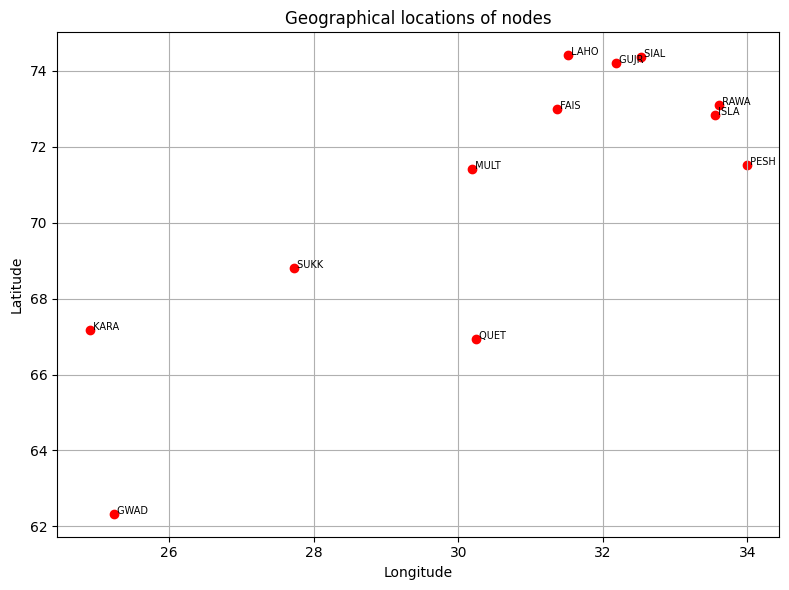

In [3]:
sortedMap=pd.read_csv('coordinates.csv')

#Displaying airpotts location
plt.figure(figsize=(8,6))
for i, row in sortedMap.iterrows():
    plt.scatter(row['Longitude'], row['Latitude'],marker='o', color='red')
    plt.text(row['Longitude'], row['Latitude'], f" {row['ICAO']}", fontsize=7, ha='left')
    
plt.title('Geographical location of airports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.grid(True)
plt.tight_layout()

plt.show()

In [4]:
def routePlotting(top_three_indexes, pops):
    
    #obtaining df object of coordinates file
    sortedMap = pd.read_csv('coordinates.csv')
    
    #declaring obj to display the nodes
    plt.figure(figsize=(8, 6))
    for i, row in sortedMap.iterrows():
        plt.scatter(row['Longitude'], row['Latitude'], marker='o', color='red')
        plt.text(row['Longitude'], row['Latitude'], f" {row['ICAO']}", fontsize=7, ha='left')
    
    #finding the top 3 routes in population, according to the indexes list.
    routes=[pops[i] for i in top_three_indexes]
    
    #setting colors to be displayed in routes that come as edges
    colors=['blue', 'green', 'red']
    
    #for all three routes
    for i in range(len(top_three_indexes)):
        
        #getting the route #i we will display 
        route = pops[top_three_indexes[i]]
        
        #printing the routes of our algorithm
        print("ROUTES ARE: ", route)
        
        #obtaining coordinates of our route nodes, from coordinates dataframe, for each node involved.
        route_coords = [sortedMap[sortedMap['ICAO'] == city][['Longitude', 'Latitude']].values[0] for city in route]
        
        #obtaining the color we are going to use
        color=colors[i]
        
        #loop plots the edges. x+1 being the 2nd node coordinate.
        for x in range(len(route_coords) - 1):
            plt.arrow(route_coords[x][0], route_coords[x][1],
                      route_coords[x+1][0] - route_coords[x][0], route_coords[x+1][1] - route_coords[x][1],
                      head_width=0.01, head_length=0.02, fc=color, ec=color, length_includes_head=True)
            
    #defining the visual labels
    plt.title('Mapped out routes, ROUTES(A,B,C): BLUE, GREEN, RED')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.tight_layout()

    #saving the image to use in html file
    plt.savefig('static/plotting.png')
    plt.show()
    
    


In [5]:
def create_population(population_size, start_ICAO, dest_ICAO, routes):
    
    #creating a tuples for comparison, so that chromosome nodes are non-repetitive
    route_tuples=set()
    
    #defining population variable list
    population=[]
    
    #keep generating more in the list until the population is full
    while len(population) < population_size:
        
        # between 2 ensuring at least a start and end node and the total number of nodes minus one
        route_length = random.randint(2,len(routes)-1)
        
        #creating chromomsome, making sure the values are not the starting and last airports
        temporaryRoute = random.sample([i for i in routes if i not in [start_ICAO, dest_ICAO]], route_length-2)
        
        #starting city and destination appended to the route.
        route=[start_ICAO] + temporaryRoute + [dest_ICAO]
        
        #using this for uniqueness of each chromosome. unless the chormomosome is unique, it wont be added
        route_tuple=tuple(route)
        if route_tuple not in route_tuples:
            population.append(route)
            route_tuples.add(route_tuple)
        
    return population

In [6]:
distance_data = pd.read_csv('Distances.csv')  

def get_distance(icao1, icao2):
    
    #getting the distance unit from the combination of two cities. 
    distance = distance_data[(distance_data['ICAO1'] == icao1) & (distance_data['ICAO2'] == icao2)]['Distance']
    
    #just a safety check incase values are empty
    if not distance.empty:
        
        #returning the distance
        return distance.values[0]
    else:
        
        #incase of failure, dist randomly generated
        return random.randint(100, 1000)

#function that returns a dictionary with travel range of each route involved in the population
def calculate_route_length(population):
    
    #declaration of distance
    distances_dict = {}
    
    #i is used as index for dictionary, chromosome enumerated #0 till #population
    for i, chromosome in enumerate(population, 1):
        
        #starter variable
        total_distance = 0
        
        #2nd loop that iterates through chromosome to add distance of every "city to city" in chromosome
        for j in range(len(chromosome) - 1):
            
            #+=
            total_distance += get_distance(chromosome[j], chromosome[j+1])
        
        #dividing result by 12.5 as the distances are too large. dummy data modification. 
        #original distances are too large for any airplane to travel
        distances_dict[i] = total_distance/12.5
        
    #returning the dictionary to main func
    return distances_dict


In [7]:
def fitnessAircraft(chromosome, chromosomeNumber, route_length, aircraft_dict, wind_speed_dict):
    
    #used for fitness function of airplanes
    totalTime=0
    totalFitness=0
    
    bestAirplanes={}
    
    #used for calculating wind effects
    totalSpeed=0
    totalGenes=0
    
    #iterate through the chromosome and find WEATHER CONDITION of every CITY
    for gene in chromosome:
        
        totalGenes=totalGenes+1
        for key in wind_speed_dict:
            if key==gene:
                totalSpeed=totalSpeed+float(wind_speed_dict[key])
    
    #finding the average weather effect on the plane
    averageSpeed=totalSpeed/totalGenes

    #subtracting the average wind speed from the airplane's IDEAL SPEED.
    for key, value in enumerate(aircraft_dict['Cruise Speed']):
        aircraft_dict['Cruise Speed'][key] = value - averageSpeed

    #adding the effect of average wind speed onto the FUEL CONSUMPTION
    for key, value in enumerate(aircraft_dict['Fuel Consumption at Cruise']):
        aircraft_dict['Fuel Consumption at Cruise'][key] = value +  float(3*averageSpeed)
    #this is done as wind resistance can make vehicle engines burn more fuel 
    
    #Setting how much KILOGRAMS OF FUEL the planes burn on an hourly rate 
    for key, value in enumerate(aircraft_dict['Cruise Speed']):
        aircraft_dict['LitresPerHour'][key] = aircraft_dict['Fuel Consumption at Cruise'][key] * value / 100
    
    #finding how much time each plane takes to travel the route
    totalDistance = route_length[chromosomeNumber]
    for key, value in enumerate(aircraft_dict['Cruise Speed']):
        aircraft_dict['timeConsumed'][key] = float(totalDistance / value)
        
    #finding the TOTAL FUEL BURNED (KILO) by planes
    for key, value in enumerate(aircraft_dict['timeConsumed']):
        aircraft_dict['fuelConsumed'][key] = aircraft_dict['LitresPerHour'][key] * value
    
    #finding the fitness based on TIME TAKEN && TOTAL FUEL CONSUMED
    for key, value in enumerate(aircraft_dict['Max Range']):
        
        #if the distance to cover is larger than the max the plane can go, it's not given any fitness.
        if float(route_length[chromosomeNumber]) < float(value):
            #plane is VIABLE if condition passed
            aircraft_dict['viability'][key]=1
            
            time_weight = 0.6 
            fuel_weight = 0.4
    
            #fitness function, combining two variables with weightages.
            fitness_score = (time_weight * aircraft_dict['timeConsumed'][key]) + (fuel_weight * aircraft_dict['fuelConsumed'][key])
            aircraft_dict['aircraftFitness'][key]=fitness_score
            
            #the lesser the fitness the better, as less FUEL and TIME consumed
    
    #sorting the dictionary of planes of the chromosome: ASCENDING ORDER, based on: FITNESS
    sorted_aircraft = sorted(range(len(aircraft_dict['aircraftFitness'])), key=lambda k: aircraft_dict['aircraftFitness'][k])
    filtered_sorted_aircraft = [key for key in sorted_aircraft if aircraft_dict['aircraftFitness'][key] != -1]
    
    #giving the TOP best plane for the chromosome. 
    top_three_aircraft = filtered_sorted_aircraft[:1]
    
    #attaching the plane to the specific route
    for i in top_three_aircraft:
        bestAirplanes[chromosomeNumber]=aircraft_dict['Aircraft Type'][i]
        
    return bestAirplanes
    

def findAircraftFitnesses(pops, date_flight, route_length):
    
    aircrafts=pd.read_csv('aircraftDataset.csv')
    
    #starting city predefined
    starting_city=pops[0][0]
    
    #making a filter which selects aircraft in the starting city
    filtered_rows = aircrafts[aircrafts['ICAO'] == starting_city]
    
    #making a filter which selects weathers of EACH CITY in THE DATE
    filtered_rows2 = weathers[weathers['Date'] == date_flight]
    wind_speed_dict = dict(zip(filtered_rows2['ICAO'], filtered_rows2['Wind Speed']))

    for chromosome_number, chromosome in enumerate(pops):
        
        #making dictionary for use in fitness calculations
        aircraft_dict = {
            'Aircraft Type': filtered_rows['Aircraft Type'].values,
            'Max Range': filtered_rows['Max Range'].values,
            'Cruise Speed': filtered_rows['Cruise Speed'].values,
            'Fuel Consumption at Cruise': filtered_rows['Fuel Consumption at Cruise'].values
        }
        aircraft_dict['LitresPerHour'] = [0] * len(filtered_rows['Aircraft Type'])
        aircraft_dict['timeConsumed'] = [0] * len(filtered_rows['Aircraft Type'])
        aircraft_dict['fuelConsumed'] = [0] * len(filtered_rows['Aircraft Type'])
        aircraft_dict['aircraftFitness'] = [-1] * len(filtered_rows['Aircraft Type'])
        aircraft_dict['viability'] = [0] * len(filtered_rows['Aircraft Type'])
        
        #running the function which returns the list of best airplanes, sorted.
        bestAirplanes = fitnessAircraft(pops[chromosome_number], chromosome_number+1, route_length, aircraft_dict, wind_speed_dict)

    return bestAirplanes


In [8]:
def crossover(selected_parents):
    
    #listing the selected parents
    selected_parents= list(selected_parents)
    
    #listing the ICAO codes availible in the system
    citiess = list(city_to_ICAO.values())
    
    #making a list of children and selecting total parents.
    children=[]
    numOfParents=2
    
    #putting them in variables
    p1, p2 = selected_parents[0], selected_parents[1]
   
    #crossover points definition. using one point crossover
    cp1 = random.randint(1, len(p1) - 1)
    cp2 = random.randint(1, len(p2) - 1)
    
    #childrens are set
    c1 = p1[:cp1] + p2[cp2:]
    c2 = p2[:cp2] + p1[cp1:]
    
    #making mutation of any 3 length parent.
    for i, parent in enumerate(selected_parents):
        if len(parent) == 3:
            
            #any cities that are not the parent starting and ending nodes themselves
            cities_except_parents = [city for city in citiess if city not in [parent[0], parent[2]]]
            
            #if they exist
            if cities_except_parents:
                
                #create a random new city from list, and replace it with the old middle city.
                new_city = random.choice(cities_except_parents) 
                selected_parents[i] = [parent[0], new_city, parent[2]]
    
    #updating the children
    c1=selected_parents[0]
    c2=selected_parents[1]
    
    #extending the list to return
    children.extend([c1, c2])
    
    return children



In [9]:
def algorithm(pops, population_size, generations, sorted_fitnesses, route_length, date_flight):
    
    #creating this to use for aircraft fitness
    bestAirplanes={}

    totalParents=2

    #assigning 0 rank to population
    ranks=[0]*population_size

    #giving rank to the sorted fitness
    for i, key in enumerate(sorted_fitnesses):
        ranks[key]=i+1

    for generation in range(generations):

        #calculate the lengths of the routes in population
        calculate_route_length(pops)

        #the routes' fitnesses aircrafts
        BA=findAircraftFitnesses(pops, date_flight, route_length)
        
        #listing the route fitness values and sorting them
        fitness_scores=list(route_length.values())
        population_size=len(fitness_scores)
        sorted_fitnesses=np.argsort(fitness_scores)
        
        #taking the top 3 routes in fitness value. TOP is lesser distance(fitness)
        top_indices = sorted(range(len(fitness_scores)), key=lambda i: ranks[i])[:totalParents]
        
        #arranging the indexes to be useable
        for i in range(len(top_indices)):
            top_indices[i]-=1
        
        #taking the top routes using the indices
        selected_parents = [route for i, route in enumerate(route_length.keys()) if i in top_indices]

        #crossover + mutation
        children = crossover(pops[sp] for sp in selected_parents)

        #re-arranging the indexes again for furhter use
        for i in range(len(top_indices)):
            top_indices[i]+=1

            
        #taking the worst 2 chromosomes in the population, to be replaced
        worst_chromosomes=sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])[:2]

        #creating a copy of the population
        tempPopulation=pops.copy()

        #if the children dont already exist in population, replace the worst chromosome with them.
        for i in worst_chromosomes:
            if children[0] not in tempPopulation:
                tempPopulation[i] = children[0]
            elif children[1] not in tempPopulation:
                tempPopulation[i]=children[1]
            else:
                pass

        #updating population
        pops=tempPopulation

    #finally selecting PLAN A B C of routes
    top_routes_indexes = sorted(range(len(fitness_scores)), key=lambda i: ranks[i])[:3]
    print("TOP ROUTE INDEXES are: ", top_routes_indexes, "\n\n")

    for index, route in enumerate(pops):
        print(f"Chromosome {index}: ", route)

    #for i in top_routes_indexes:
        #print(f"\nSELECTED ROUTE: {i}: ", pops[i], '\n')

    #dictionary that holds the top routes and their aircrafts.
    final_selection={}
    for i in top_routes_indexes:
        final_selection[i] = [pops[i], BA.get(i+1)]

    #display of the airplanes and routes.
    for key, values in final_selection.items():
        print(f"\nIndex {key}: Route - {' -> '.join(values[0])}, Best Airplane - {values[1]}")
        
    
    return top_routes_indexes, pops


In [10]:

def GA(SI, DI, DF):
    
    #inititaing values from input
    start_ICAO=SI
    dest_ICAO=DI
    date_flight=DF

    #opening file to take all city codes
    distances_file=pd.read_csv('distances.csv')
    routes = list(city_to_ICAO.values())
    
    #population and generation setting
    popsize=100
    generations=50

    def geneticAlgorithm(start_ICAO, dest_ICAO, date_flight):
        
        #create the population
        pops=create_population(popsize, start_ICAO, dest_ICAO, routes)

        #find the distances of the chromomsomes(AKA ROUTES)
        route_length=calculate_route_length(pops)

        #listing the distances 
        fitness_scores=list(route_length.values())

        #sorting the list ASCENDING ORDER
        sorted_fitnesses=np.argsort(fitness_scores)
        
        
        #algo run
        selectedRoutes, pops = algorithm(pops, popsize, generations, sorted_fitnesses, route_length, date_flight)

        #plot routes.
        routePlotting(selectedRoutes, pops)

    geneticAlgorithm(start_ICAO, dest_ICAO, date_flight)

In [11]:
app = Flask(__name__, static_url_path='/static')

#first page render
@app.route('/')
def firstPage():
    
    return render_template('firstPage.html')

#post pressing button, function loads the algorithm and goes to next page for route display.
@app.route('/run_algorithm', methods=['POST'])
def run_algorithm():
    
    #taking inputs from forms.
    start_ICAO = request.form['start_ICAO']
    dest_ICAO = request.form['dest_ICAO']
    date_flight = request.form['date_flight']
    
    
    #genetic algorithm
    GA(start_ICAO, dest_ICAO, date_flight)
    
    #using os path join to send static/plotting to next page for display.
    graph=os.path.join('static', 'plotting.png')
    
    #return function renders next page and the filepath of the result.
    return render_template('Result.html', plot_path=graph)
    
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [25/Dec/2023 20:13:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Dec/2023 20:13:46] "GET /static/background.jpg HTTP/1.1" 304 -
127.0.0.1 - - [25/Dec/2023 20:13:47] "GET /favicon.ico HTTP/1.1" 404 -
